### This file runs the eigenface (section 5) and face tagging (section 6) sections

In [1]:
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
import json
import sys
from copy import deepcopy

# EigenFaces

In [2]:
# grab the original images
def clean_filename(path):
    strings = path.split('/')
    return strings[-1]

def squeeze_image(img):
    # squeezing array values between 0, 1
    # some array elements are negative
    # using formula (X - min(X)) / (max(X) - min(X))
    min_element = np.min(img)
    max_element = np.max(img)
    img_copy = deepcopy(img) - min_element
    max_min_diff = max_element - min_element
    return img_copy / max_min_diff

def d_matrix(images, lbls):
    D = []
    D_labels = []
    # D is the matrix that contians the vectors of all the training images
    for i in images:
        D_labels.append(lbls[i])
        dataMatrix_train = np.array([images[i]])
        dataMatrix_train = dataMatrix_train.flatten()
        D.append(dataMatrix_train)
    return D, D_labels

def instantiate_PCA(train_set, num_components):
    pca = PCA(n_components=num_components, whiten=True)
    pca.fit(train_set)
    return pca


def get_num_components(train_set):
    pca = instantiate_PCA(train_set, 75)
    
    percentage = .92
    total_var = np.sum(pca.explained_variance_)
    sum_var = 0
    for i, var in enumerate(pca.explained_variance_):
        sum_var += var
        if sum_var / total_var >= percentage:
            break
            
    plt.plot([x for x in range(75)], pca.explained_variance_)
    plt.title("Variance Vs Num Components")
    plt.show()
    print("First {} components yield {}% variance".format(i+1, percentage*100))
    return i+1

def run_eigen_face(num_components, train, test, train_labels, test_labels):
    pca = instantiate_PCA(train, num_components)
    
    #show first 5 eigen faces
    for i in range(5):
        plt.imshow(squeeze_image(pca.components_[i].reshape(train_images['train0.jpg'].shape) ))
        plt.show()
    
    # apply PCA transformation to test and train
    X_train_pca = pca.transform(train)
    X_test_pca = pca.transform(test)
    
    # for each test image in face space
    # find nearest train image in face space
    pred = []
    for i,test_eigen in enumerate(X_test_pca):
        minVal = sys.maxsize
        currLabel = 1
        
        for j,train_eigen in enumerate(X_train_pca):
            dist = np.linalg.norm(test_eigen - train_eigen)

            if dist < minVal:
                currLabel = train_labels[j]
                minVal = dist
                
        pred.append(currLabel)
    
    accuracy = accuracy_score(pred, test_labels)
    print ("Accuracy = {}".format(accuracy*100))
    
    conf = confusion_matrix(test_labels, pred)
    
    # We can plot images using pyplot.imshow
    plt.figure()
    plt.title('Eigenfaces')
    plt.imshow(conf)
    return pca
    
    

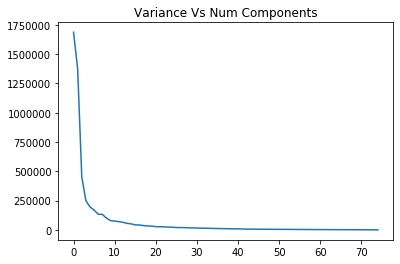

First 22 components yield 92.0% variance


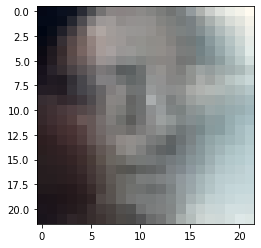

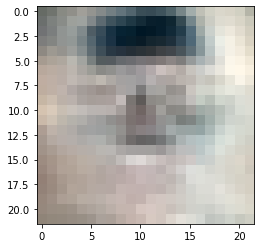

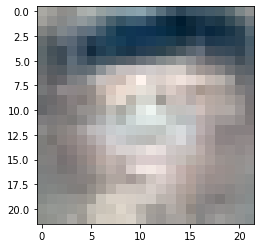

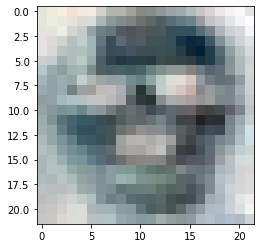

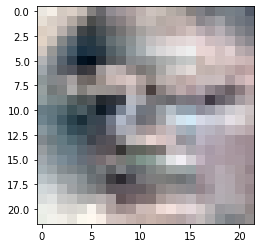

Accuracy = 64.28571428571429


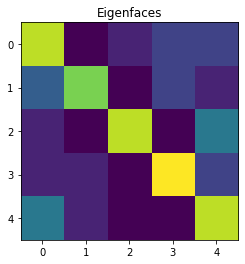

In [3]:
train_images = {}
test_images = {}

#assigns all training and test images to dictionary
for i in range(0, 75):
    file = "./pictures/train_cropped/train" + str(i) + ".jpg"
    train_images["train" + str(i) + ".jpg"] = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)   
for j in range(0,70):
    file = "./pictures/test_cropped/test" + str(j) + ".jpg"
    test_images["test" + str(j) + ".jpg"] = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
    
with open("pictures/test/labels.json") as f:
    test_labels = json.load(f)

with open("pictures/train/labels.json") as f:
    labels = json.load(f)
    
d_train, d_labels = d_matrix(train_images, labels)
d_test, d_test_labels = d_matrix(test_images, test_labels)

# check which components yield 92% variance
num_comps = get_num_components(d_train)

classifier = run_eigen_face(num_comps, d_train, d_test, d_labels, d_test_labels)


# Face Tagging

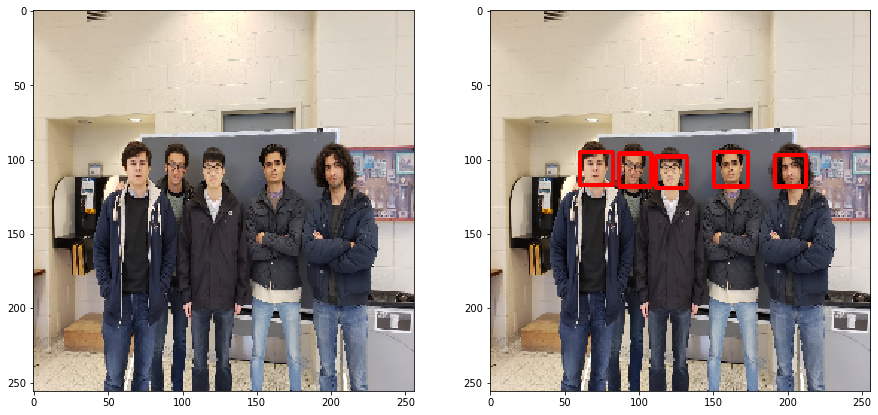

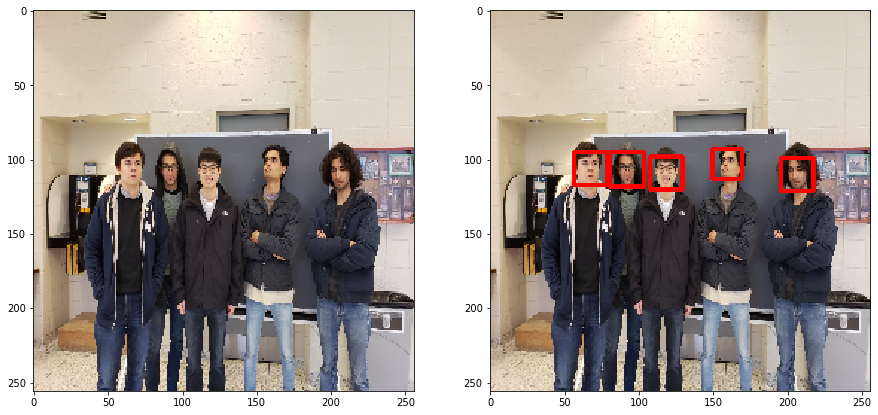

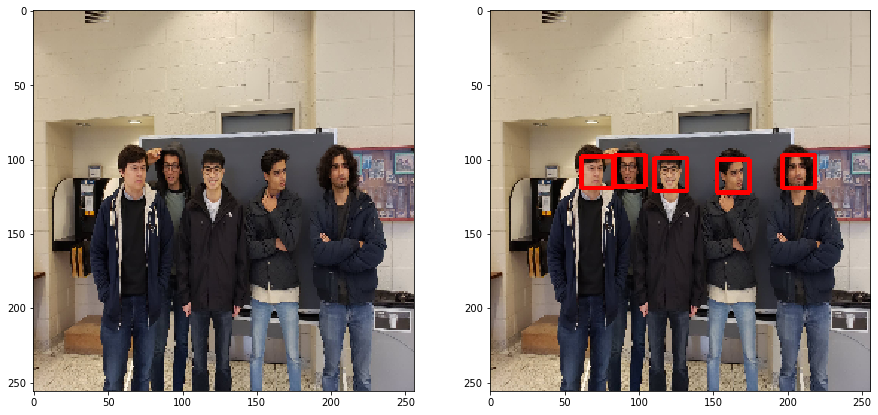

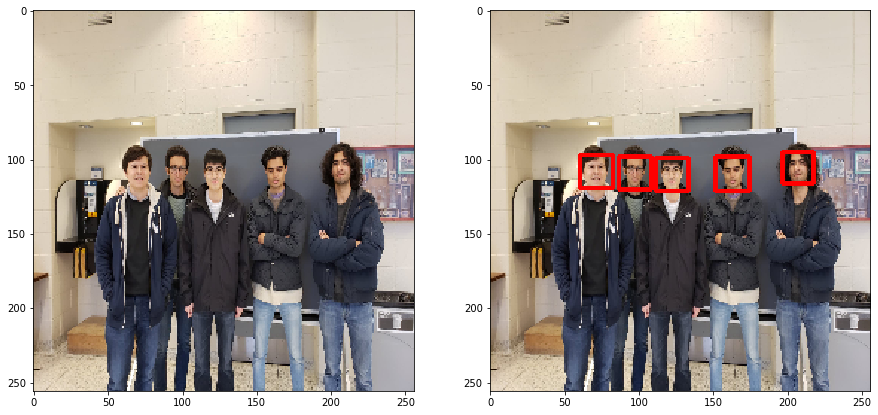

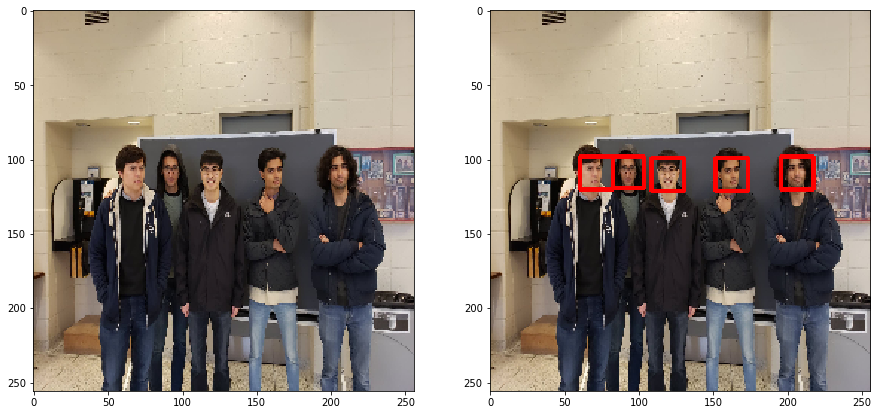

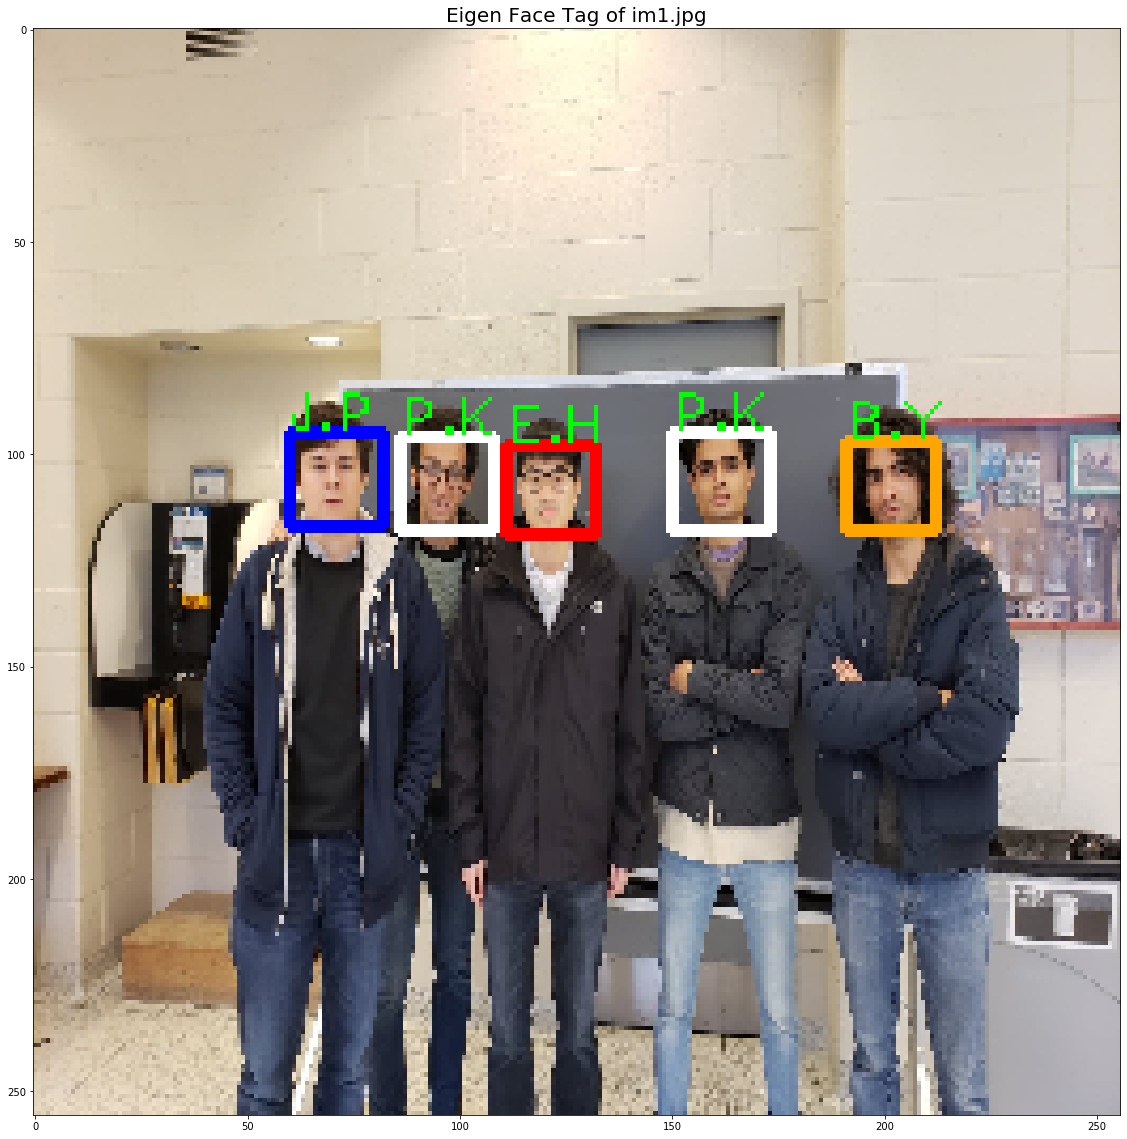

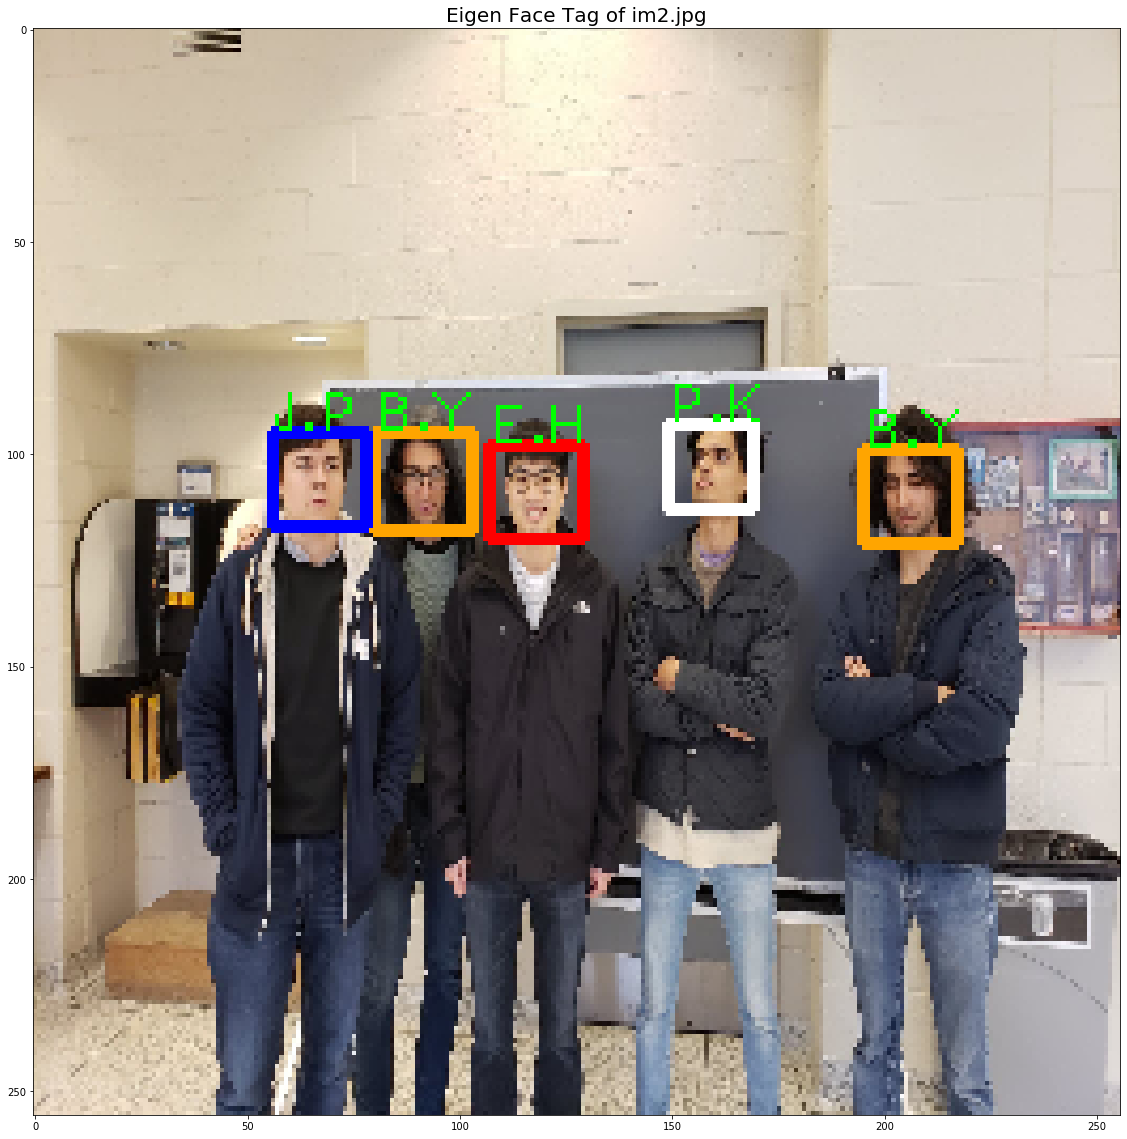

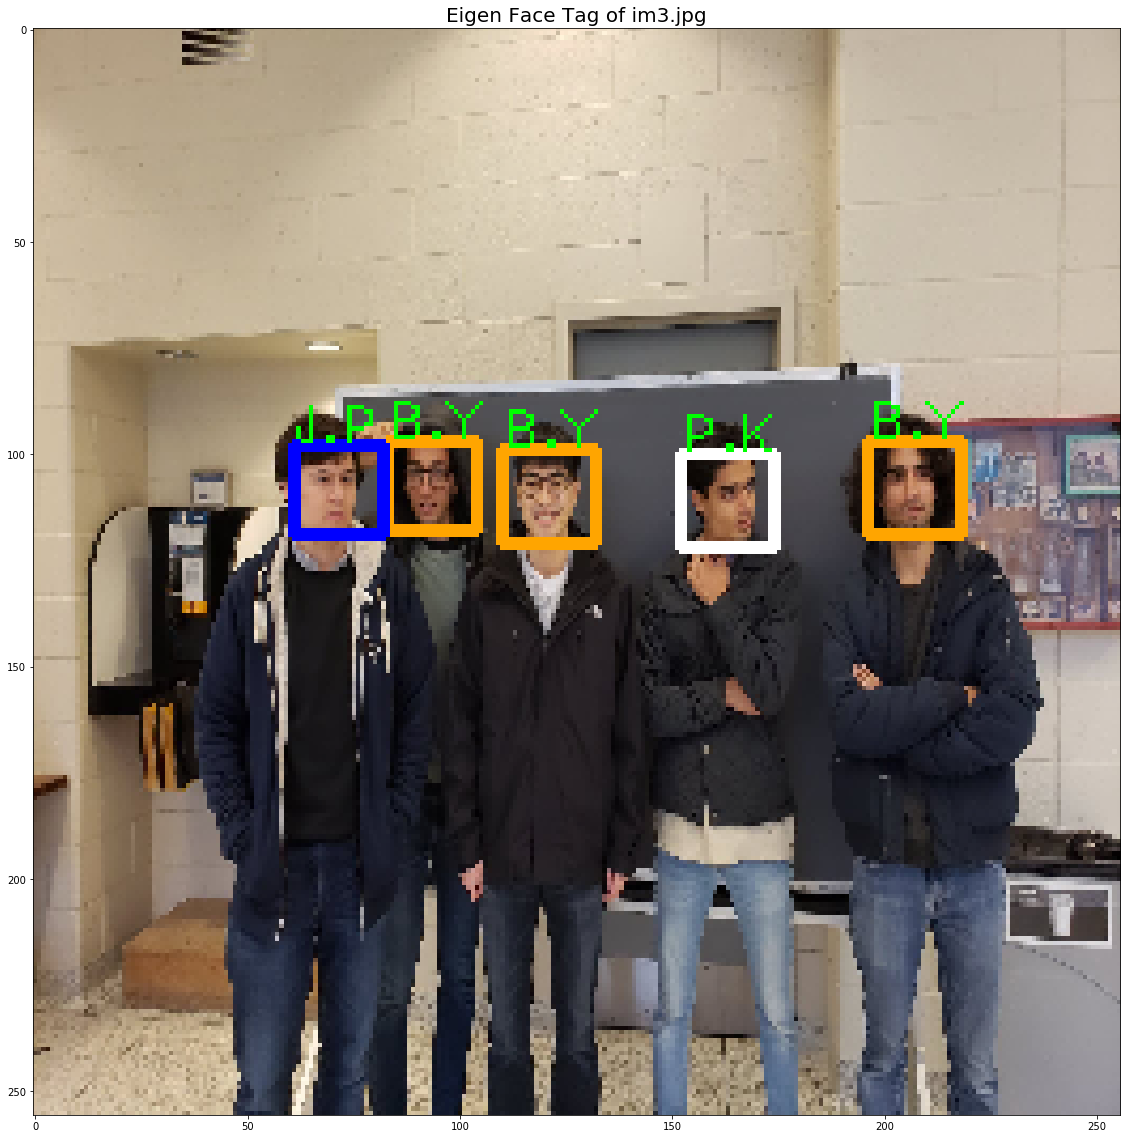

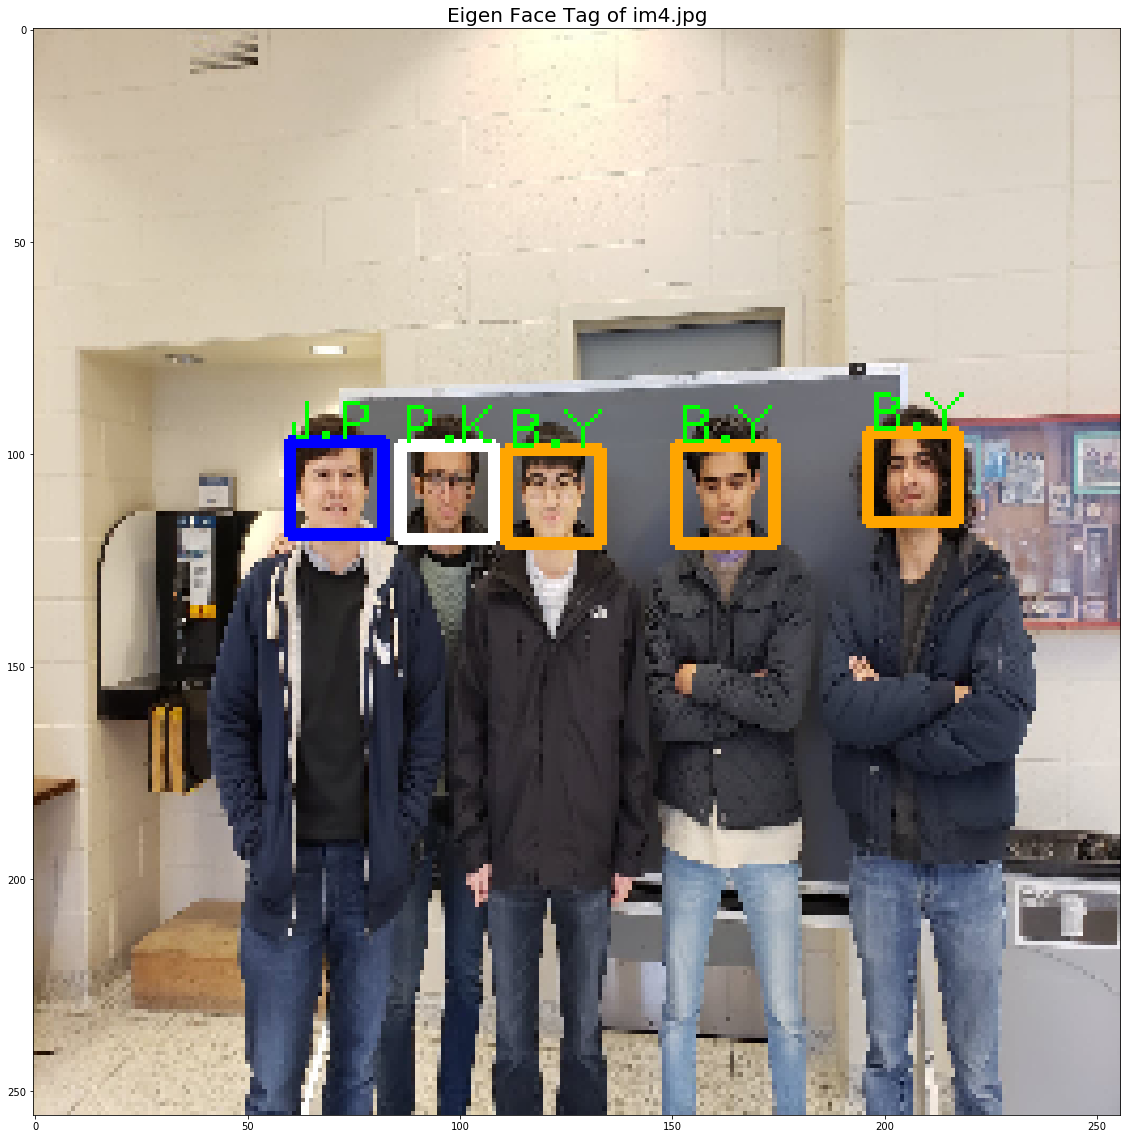

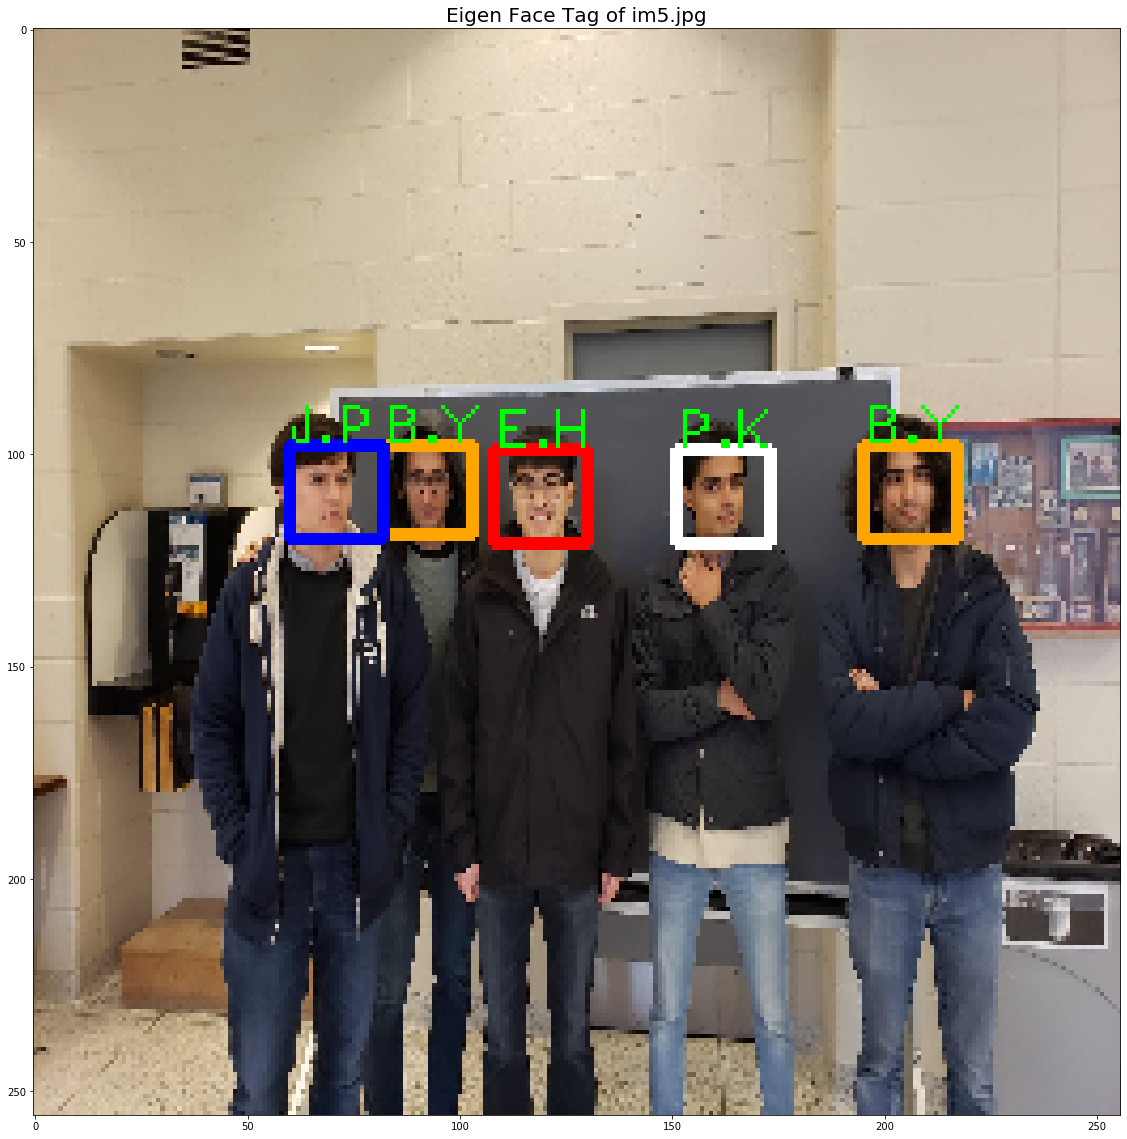

Tagging Accuracy = 0.68


In [4]:
# Using initials instead of the name
label_to_name = {
    0 : "B.Y",
    1: "E.H",
    2: "J.L",
    3: "J.P",
    4: "P.K"
}

label_to_color =  {
    0 : (255, 165, 0),
    1: (255, 0, 0),
    2: (0, 255, 0),
    3: (0,0,255),
    4: (255, 255, 255)
}

# do not change the order of the arrays
# they are aligned so that array[0] = face for label 0
face_coords = {
    "im1.jpg": [[191, 97, 21, 21],  [111, 98, 21, 21], [86, 96, 22, 22], [60,  95,  22,  22], [150,  95,  23,  23]],
    "im3.jpg": [[196, 97, 22, 22], [110, 99, 22, 22], [ 83, 97, 21, 21], [ 61, 98, 21, 21], [152, 100, 22, 22]],
    "im2.jpg": [[195, 99, 22, 22], [107, 98, 22, 22], [ 80, 95, 23, 23], [ 56, 95, 22, 22], [149, 93, 20, 20]],
    "im5.jpg": [[195, 98, 22, 22], [108, 99, 22, 22], [ 82, 98, 21, 21], [ 60, 98, 22, 22], [151, 99, 22, 22]],
    "im4.jpg": [[196, 95, 21, 21], [111, 99, 22, 22], [ 86, 98, 22, 22], [ 60, 97, 22, 22], [151, 98, 23, 23]]
}

train_fs = classifier.transform(d_train)
pred = []

group_pics = {}

for i in range(1,6):
    file = "./pictures/group/im" + str(i) + ".jpg"
    img = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256,256))
    group_pics[clean_filename(file)] = img
    
# for file in glob.glob("pictures/group/*.jpg"):
#     img = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
#     img = cv2.resize(img, (256,256))
#     group_pics[clean_filename(file)] = img
    
for key in group_pics: 
    cpy = deepcopy(group_pics[key])     
    fig, ax = plt.subplots(1,2, figsize=(15,15))
    ax[0].imshow(group_pics[key])
    for x,y,w,h in face_coords[key]:
        cv2.rectangle(cpy, (x, y), (x+w, y+h), (255), thickness = 2)
    ax[1].imshow(cpy)
    plt.show()
    
    

for key in group_pics:
    faces = face_coords[clean_filename(key)]
    cpy = deepcopy(group_pics[key])     
    for x, y, w, h in faces:
        crop = cpy[y : y + h, x : x + w]
        # resize cropped face to ensure transform operation is possible
        # resize to 22x22 since that is how big our cropped face images are
        crop = cv2.resize(crop, (22,22))
        fs = classifier.transform(np.array([crop.flatten()]))
        minVal = sys.maxsize
        label = -1
        
        for j,train_eigen in enumerate(train_fs):
            dist = np.linalg.norm(fs - train_eigen)

            if dist < minVal:
                label = d_labels[j]
                minVal = dist
                
        pred.append(label)
        cv2.rectangle(cpy, (x, y), (x+w, y+h), label_to_color[label], 2)
        cv2.putText(cpy, label_to_name[label], (x, y), cv2.FONT_HERSHEY_PLAIN, .9, (0,255,0))
        
    plt.figure(figsize=(20,20))
    plt.title("Eigen Face Tag of {}".format(key), fontsize=20)
    plt.imshow(cpy)
    plt.show()
    
accuracy = accuracy_score([0,1,2,3,4]*5, pred)
print("Tagging Accuracy = {}".format(accuracy))
    
    
